# Unsupervised exploration of NIST Beamline 2 Data
## Findings:
* Preamp saturation is common enough and has different starting points so it throws off much of the analysis
* The real signals have a low signal to noise ratio
* The real signals have a lot of shape variation
* There seems to be a ringing in the tails around time bin 1500 - possibly some sort of data acquisition problem
## General Approach:
* Apply a clustering method/cut
* plot all the cluster centers
* investigate any unexpected signals and find what causes edge behavior

## Imports

In [2]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from numba import jit
import os

## Read in data
I read in a single file at first, but realized I did not have enough information to be productive. I went back and compiled a whole bunch of files into one big batch and worked on that from there

In [6]:
#def read_bl2(path):
#    return np.core.records.fromfile(str(path),formats='f8,(2048)i2,f8,(2048)i2',shape=398,names='tstamp,pwave,ptime,wave')

In [7]:
#data = read_bl2('s_0537_r_000312_1.dat')['wave']

REDO WITH LARGER DATASET

This is run 717 ending in _1.dat

In [8]:
data = np.load('100K_dataset.npy')

### shuffling - this is to prevent some sort of bias from selecting data in one portion of the data

In [8]:
@jit(nopython=True)
def scramble(data):
    np.random.shuffle(data)

In [9]:
scramble(data[:10])
scramble(data)

In [9]:
X = data

Just a quick visualization of the data

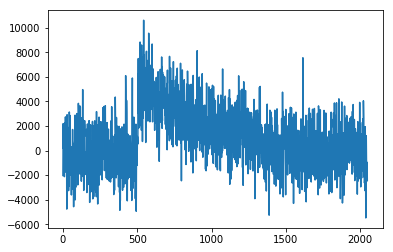

In [11]:
plt.plot(X[-1])

## getting amplitudes
This uses the Jordanov and Knoll Trapezoidal filter derived from a derivative of the Moving Windo Deconvolution to extract the maximum

In [12]:
def amplitudes(data):
    ## Get trapezoid filter
    tau = np.int(350)
    rise = np.int(100)
    top = np.int(50)
    trap = np.empty(2048)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 2048):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)

    # Get amplitudes
    f = np.fft.irfft(np.fft.rfft(data)*trapNew)
    E = np.amax(f, 1, keepdims=True)
    E -= np.mean(f[:,:100], 1, keepdims=True)
    return E

In [13]:
E = amplitudes(X)

A quick histogram of the data. This should be two peaks, where the leftmost peak is large and the right peak is smaller. This describes events with one proton detected and events with two protons detected

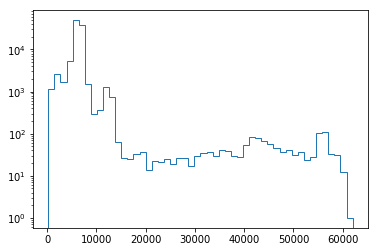

In [14]:
plt.hist(E, bins=50, histtype='step');
plt.yscale('log')

## normalizing -1 to 1
This means that the distance metrics act over the shape, not the pulse amplitude

In [15]:
@jit(nopython=True)
def normBatch(data):
    x = data.astype(np.float32)
    for i in range(len(data)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1 
    return x

In [16]:
x = X[:20]
x = normBatch(x)

In [17]:
X = normBatch(X)

## K means clustering

### How many clusters should I use?
The metric recorded, "score", measures the sum of squared differences to the cluster center. There should be an elbow as the number of clusters actually fits the data better

In [18]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [19]:
maxClusters = 20
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = KMeans(n_clusters=numClusters, n_jobs=7).fit(X[:10000])
    res2[numClusters-2] = kmean.score(X[:10000])

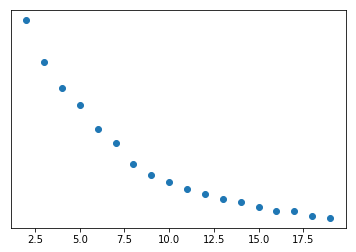

In [20]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

### 10 isn't perfect but covers a lot, so now let's train with more data

In [19]:
kmean = KMeans(n_clusters=10, n_init=20).fit(X[:10*1000])

This is just a saving routine

In [20]:
import pickle

In [21]:
with open('jimmy_kmean', 'wb') as file:
    pickle.dump(kmean, file)

In [22]:
#with open('jimmy_kmean', 'rb') as file:
#    kmean = pickle.load(file)

Now I plot all the cluster centers. It is clear that this is picking up on a few different noise features, such as pileup that are causing the weird shapes

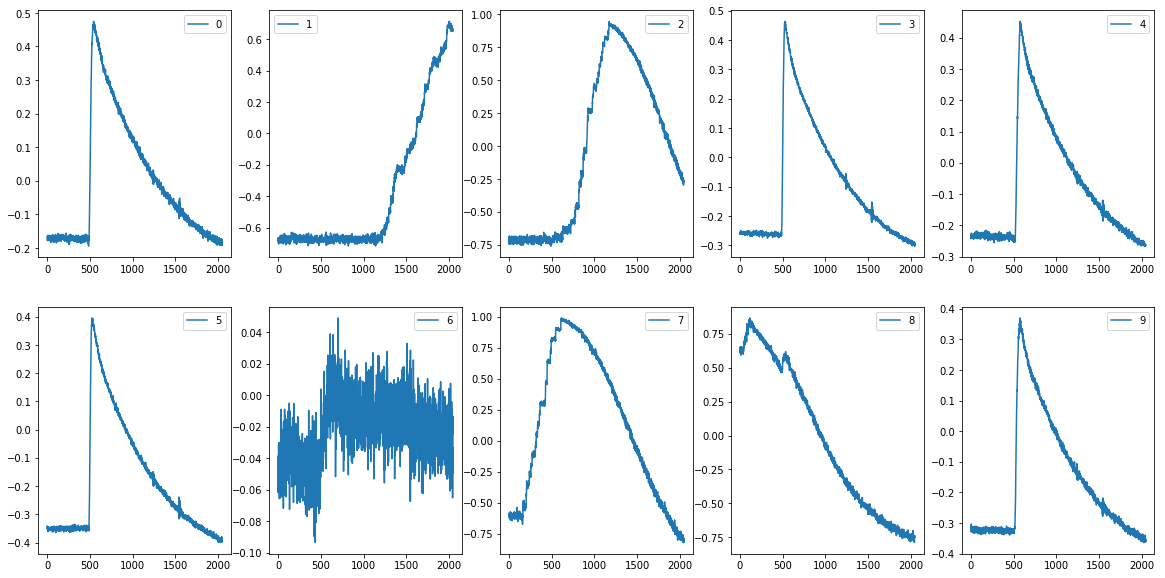

In [23]:
fig = figure(figsize=(20,10))
for i in range(len(kmean.cluster_centers_)):
    subplot(2,5,i+1)
    plot(kmean.cluster_centers_[i], label=str(i))
    legend()

Something weird is going on with a few of them, but that's the preamp saturation

In [24]:
clusterIDs = kmean.labels_

In [27]:
clusterE = [np.array([E[j] for j in range(len(kmean.labels_)) if clusterIDs[j]==i]) for i in range(kmean.cluster_centers_.shape[0])]

Now I plot them to see what percent of the data they are

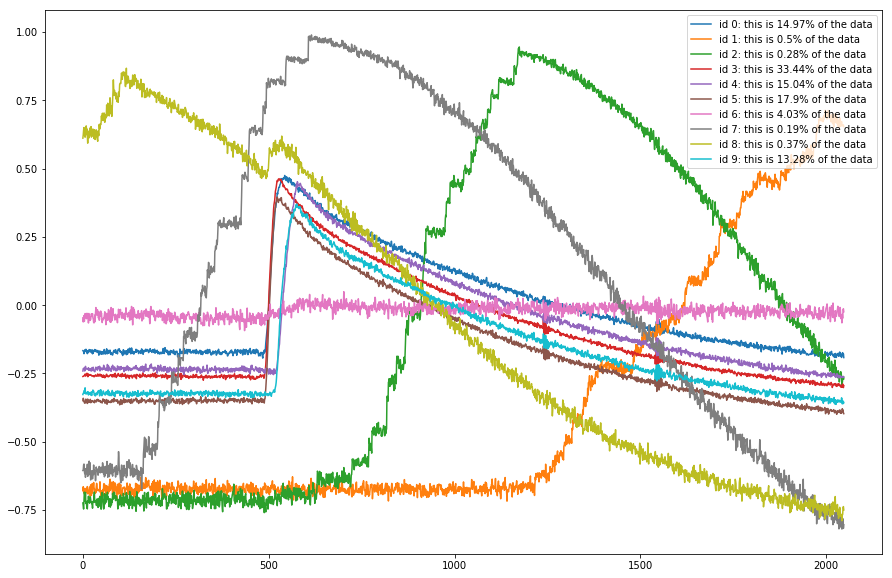

In [29]:
fig = figure(figsize=(15,10))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(100*len(clusterE[i])/len(kmean.labels_))+'% of the data')
legend()

## Let's run with more clusters and see what happens

In [32]:
k = KMeans(n_clusters=15, n_init=10).fit(X[:10000])

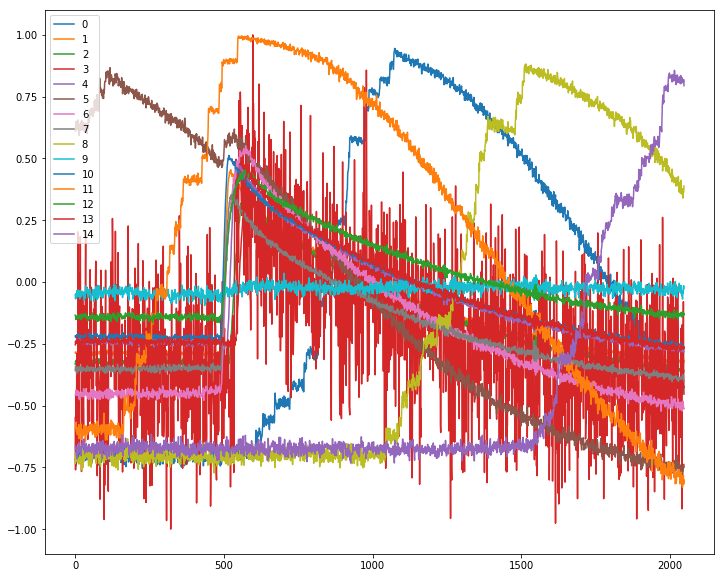

In [33]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

## Here's with an Energy cut
### Now it's really obvious that the weird shapes are from preamp saturation

In [36]:
Cutoff = 10000
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(np.array([X[i] for i in range(len(X)) if E[i]>Cutoff]))

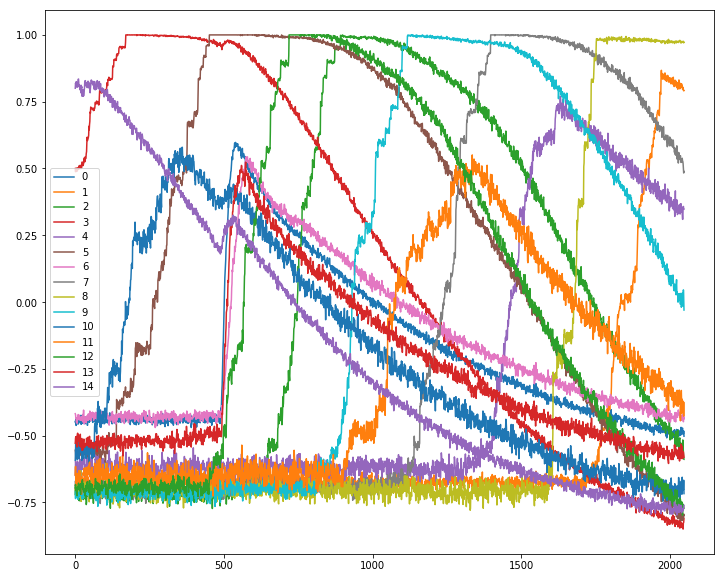

In [37]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

# Trying other methods.
## This doesn't wind up giving anything new, but I leave it in
These methods are taking a heck of a lot longer than k means clustering, so it had better look pretty 

In [57]:
N = 10000

In [59]:
from sklearn.cluster import AgglomerativeClustering

In [106]:
spectre = AgglomerativeClustering(n_clusters=10)

In [107]:
N = 10000

In [108]:
spectre.fit(X[:N])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=10,
                        pooling_func='deprecated')

In [109]:
list(set(spectre.labels_))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [110]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,2048))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

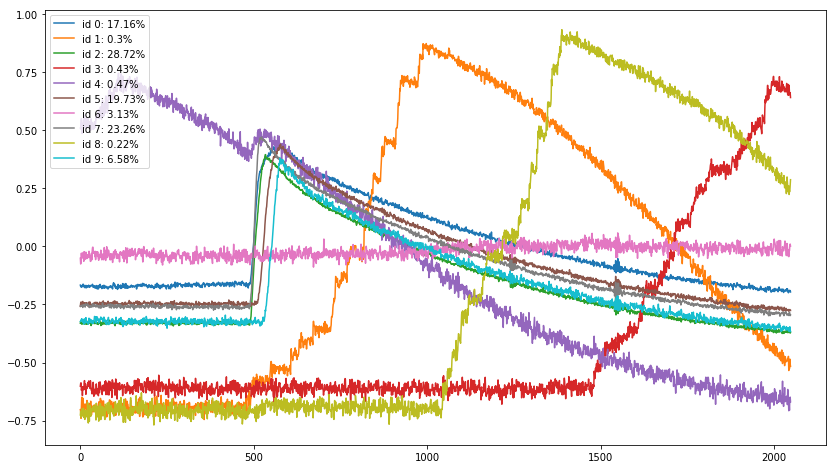

In [111]:
f = plt.figure(figsize=(14,8))
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(np.around(100*spectreCount[i],2))+'%')
    plt.legend()

In [115]:
bad_ones = []
for i in range(len(spectre.labels_)):
    if (spectre.labels_[i] == 1):
        bad_ones.append(i)

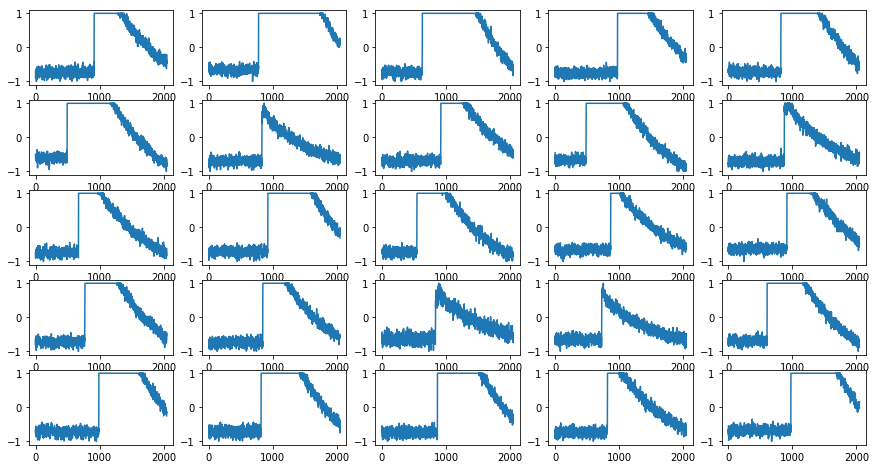

In [117]:
f = plt.figure(figsize=(15,8))
for i in range(min(len(bad_ones),25)):
    plt.subplot(5,5,i+1)
    plt.plot(X[bad_ones[i]])

In [67]:
spectre = AgglomerativeClustering(n_clusters=8, linkage='ward')

In [68]:
N = 1000*10

In [69]:
spectre.fit(X[:N])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8,
                        pooling_func='deprecated')

In [70]:
list(set(spectre.labels_))

[0, 1, 2, 3, 4, 5, 6, 7]

In [72]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,2048))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

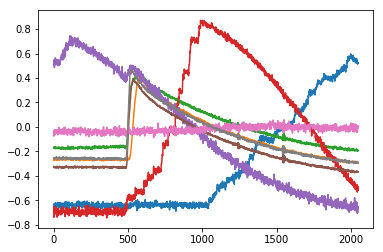

In [73]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [74]:
spectre = AgglomerativeClustering(n_clusters=14, linkage='ward')

In [75]:
N = 1000*10

In [76]:
spectre.fit(X[:N])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=14,
                        pooling_func='deprecated')

In [77]:
list(set(spectre.labels_))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [78]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,2048))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

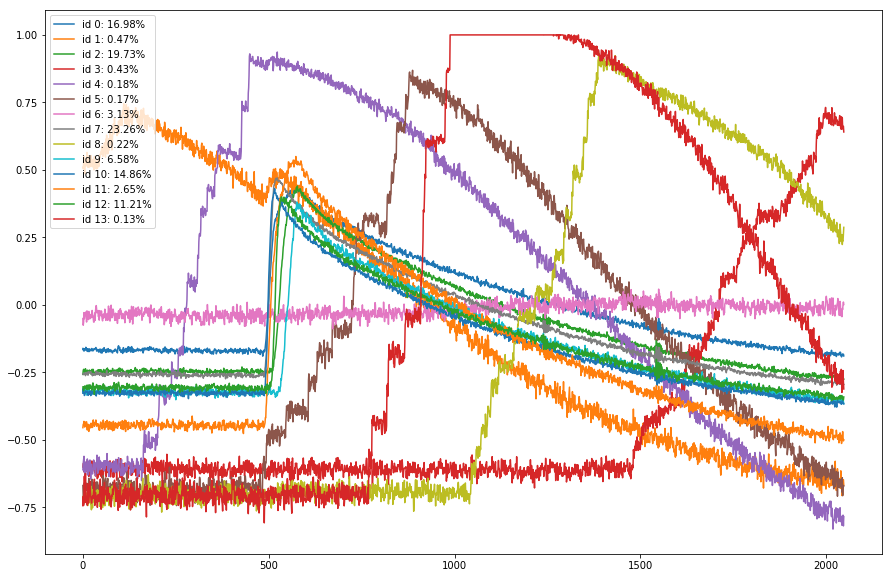

In [82]:
f = plt.figure(figsize=(15,10))
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(np.around(100*spectreCount[i],3))+'%')
    plt.legend()

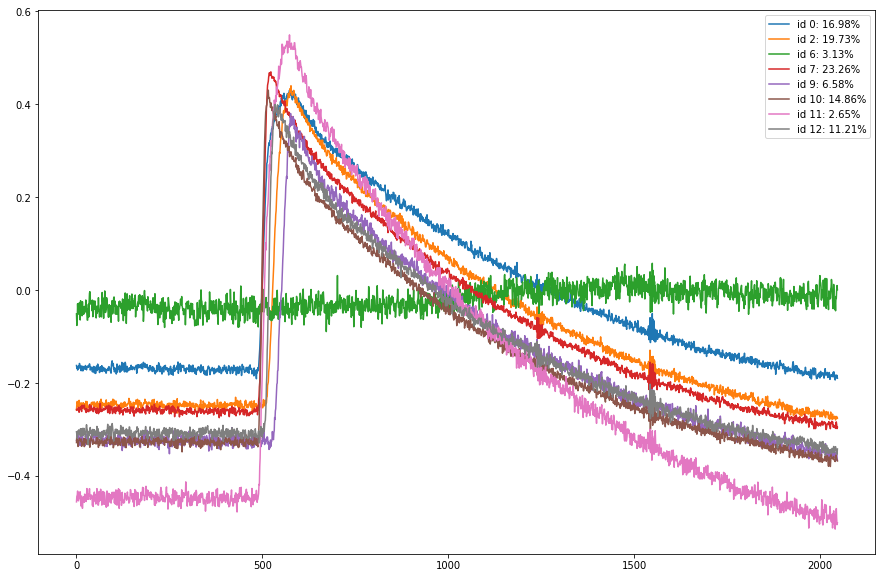

In [85]:
f = plt.figure(figsize=(15,10))
for i in range(numCenters):
    if (np.around(100*spectreCount[i],3) > 0.5):
        plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(np.around(100*spectreCount[i],3))+'%')
        plt.legend()

In [86]:
bad_ones = []
for i in range(len(spectre.labels_)):
    if (spectre.labels_[i] == 8):
        bad_ones.append(i)

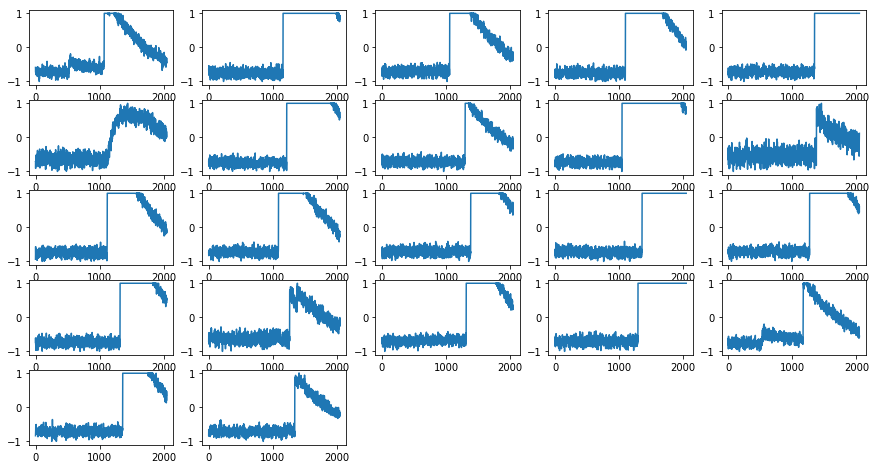

In [94]:
f = plt.figure(figsize=(15,8))
for i in range(len(bad_ones)):
    plt.subplot(5,5,i+1)
    plt.plot(X[bad_ones[i]])

# Results
* Preamp saturation is common enough and has different starting points so it throws off much of the analysis
* The real signals have a low signal to noise ratio
* The real signals have a lot of shape variation
* There seems to be a ringing in the tails around time bin 1500 - possibly some sort of data acquisition problem